# Statistical Forecasting of Close Value, Returns, and Volatility
- Work in Progress
- AR/ARMA/ARIMA/GARCH modelling

In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from crypr.util import get_project_path

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs

import arch
from arch.univariate import ARX, GARCH
from arch.univariate import StudentsT

In [2]:
"""
Set plotting style.
"""
plt.style.use('bmh')

In [3]:
"""
Import Data.
"""
SYM = 'BTC'
data_path = join(get_project_path(), 'data', 'raw', SYM + '.csv')
data = pd.read_csv(join(data_path), usecols=['close', 'time'], index_col='time')
data.head()

,close
time,
1533398400,6990.50
1533402000,6994.01
1533405600,6987.21
1533409200,6999.45
1533412800,6992.18


In [4]:
"""
Calculate signals.
"""
data['log_returns'] = np.log(data.close / data.close.shift(1))
data['percent_change'] = data.close.pct_change()
data.head()

,close,log_returns,percent_change
time,,,
1533398400,6990.50,NaN,NaN
1533402000,6994.01,0.000502,0.000502
1533405600,6987.21,-0.000973,-0.000972
1533409200,6999.45,0.001750,0.001752
1533412800,6992.18,-0.001039,-0.001039


In [5]:
"""
Set analysis vars.
"""
Y = data['log_returns'].dropna()
Y.index = pd.DatetimeIndex(pd.date_range(Y.index[0]*1000000000, freq='H', periods=len(Y.index)))

max_lag = 30
freq = 'H'
forecast_steps = 21
forecast_idx = pd.date_range(Y.index[-1], periods=forecast_steps, freq=freq)

Y.head()

2018-08-04 17:00:00    0.000502
2018-08-04 18:00:00   -0.000973
2018-08-04 19:00:00    0.001750
2018-08-04 20:00:00   -0.001039
2018-08-04 21:00:00    0.000759
Freq: H, Name: log_returns, dtype: float64

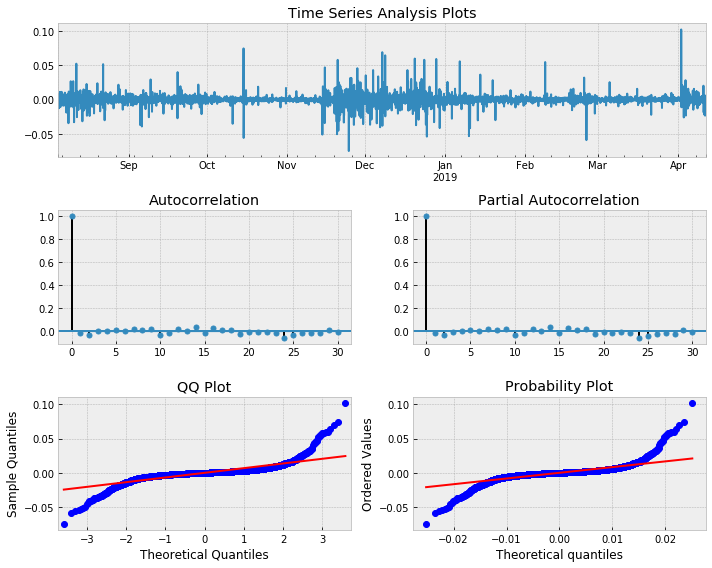

In [6]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh') -> None: 
    fig = plt.figure(figsize=figsize)
    layout = (3, 2)

    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    ts_ax.set_title('Time Series Analysis Plots')
    y.plot(ax=ts_ax)

    acf_ax = plt.subplot2grid(layout, (1, 0))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)

    pacf_ax = plt.subplot2grid(layout, (1, 1))
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

    qq_ax = plt.subplot2grid(layout, (2, 0))
    qq_ax.set_title('QQ Plot') 
    sm.qqplot(y, line='s', ax=qq_ax)

    pp_ax = plt.subplot2grid(layout, (2, 1))
    scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

    plt.tight_layout()

tsplot(Y, lags=max_lag)

In [7]:
# Select best lag order for crypto returns using Autoregressive (AR) Model
ar_lag_order_estimate = smt.AR(Y, freq=freq).select_order(maxlag=max_lag, ic='aic', trend='nc')
p('best estimated lag order =', ar_lag_order_estimate)

best estimated lag order = 28


In [8]:
# Fit MA(3) to crypto returns
arma_mdl = smt.ARMA(Y, order=(0, 3), freq=freq).fit(maxlag=max_lag, method='mle', trend='nc')
arma_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            log_returns   No. Observations:                 5998
Model:                     ARMA(0, 3)   Log Likelihood               21407.589
Method:                           mle   S.D. of innovations              0.007
Date:                Mon, 15 Apr 2019   AIC                         -42807.179
Time:                        11:44:14   BIC                         -42780.382
Sample:                    08-04-2018   HQIC                        -42797.873
                         - 04-11-2019                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ma.L1.log_returns    -0.0182      0.013     -1.406      0.160      -0.043       0.007
ma.L2.log_returns    -0.0297      0.013     -2.312      0.021      -0.055      -0.005
ma.L3.log_returns     0.0012      0.013      0.097      0.923      -0.024       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -5.4816           +0.0000j            5.4816            0.5000
MA.2            6.3693           +0.0000j            6.3693            0.0000
MA.3           22.9453           +0.0000j           22.9453            0.0000
-----------------------------------------------------------------------------
"""

# ARMA

In [9]:
def _get_best_arma(TS):
    best_aic = float('inf')
    best_order = None
    best_mdl = None

    for i in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARMA(TS, order=(i, j)).fit(method='mle', trend='nc', freq=freq)
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j)
                    best_mdl = tmp_mdl
            except: continue
    p('ARMA Results:', 'best aic = {:6.5f} | best order = {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

arma_aic, arma_order, arma_mdl = _get_best_arma(Y)

/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/.conda/envs/crypto_predict/

ARMA Results: best aic = -42833.64242 | best order = (4, 2)


# ARIMA

In [10]:
def _get_best_arima(TS):
    best_aic = float('inf')
    best_order = None
    best_mdl = None

    pq_rng = range(5)
    d_rng = range(2)
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i, d, j)).fit(method='mle', trend='nc', freq=freq)
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('ARIMA Results: best aic = {:6.5f} | best order = {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [11]:
arima_aic, arima_order, arima_mdl = _get_best_arima(Y)

/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.

ARIMA Results: best aic = -42833.64242 | best order = (4, 0, 2)


# Predict Volatility with ARIMA

In [12]:
# Create an hourly forecast of crypto returns with 95%, 99% CI
f, err95, ci95 = arima_mdl.forecast(steps=forecast_steps) # 95% CI
_, err99, ci99 = arima_mdl.forecast(steps=forecast_steps, alpha=0.01) # 99% CI

fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=forecast_idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=forecast_idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2019-04-11 14:00:00,-0.000755,-0.014083,-0.018271,0.012574,0.016762
2019-04-11 15:00:00,-0.000841,-0.014173,-0.018362,0.012491,0.016681
2019-04-11 16:00:00,-0.000710,-0.014050,-0.018241,0.012630,0.016822
2019-04-11 17:00:00,-0.000667,-0.014007,-0.018199,0.012673,0.016864
2019-04-11 18:00:00,-0.000604,-0.013944,-0.018136,0.012736,0.016928


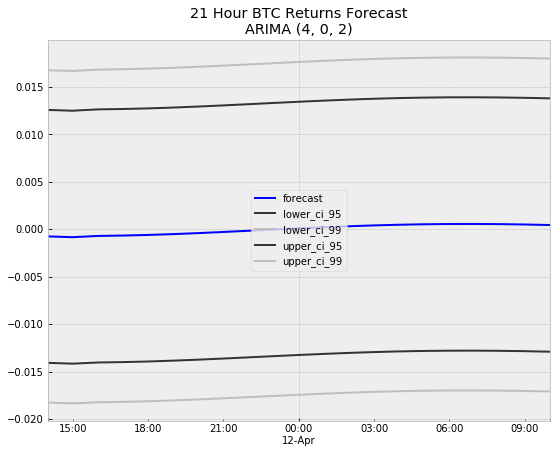

In [13]:
# Plot forecast for crypto returns
fig, ax = plt.subplots(figsize=(9, 7))
styles = ['b-', '0.2', '0.75', '0.2', '0.75']

fc_all.plot(style=styles, ax=ax)

plt.fill_between(fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)

plt.title('{} Hour {} Returns Forecast\nARIMA {}'.format(forecast_steps, SYM, arima_order))
plt.legend(loc='best', fontsize=10)
plt.show()

# GARCH based on ARIMA

In [14]:
# fit the arch model using the best fit arima model parameters
p_, o_, q_ = arima_order

# Using student T distribution usually provides better fit
arch_mdl = arch.arch_model(arima_mdl.resid, p=p_, o=o_, q=q_, vol='GARCH', dist='StudentsT')
arch_res = arch_mdl.fit(update_freq=5, disp='off')
arch_res.summary()

/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                24311.5
Distribution:      Standardized Student's t   AIC:                          -48605.0
Method:                  Maximum Likelihood   BIC:                          -48544.8
                                              No. Observations:                 5998
Date:                      Mon, Apr 15 2019   Df Residuals:                     5989
Time:                              11:46:12   Df Model:                            9
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.2481e-05  2.912e-05     -1.802  7.151e-02 [-1.096e-04,4.593e-06]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.2486e-07  2.404e-08     38.472      0.000  [8.777e-07,9.720e-07]
alpha[1]       0.0125  8.267e-03      1.512      0.131 [-3.703e-03,2.870e-02]
alpha[2]       0.0125  8.271e-02      0.151      0.880      [ -0.150,  0.175]
alpha[3]       0.0125  9.755e-02      0.128      0.898      [ -0.179,  0.204]
alpha[4]       0.0125  6.831e-02      0.183      0.855      [ -0.121,  0.146]
beta[1]        0.4650      0.729      0.638      0.524      [ -0.964,  1.894]
beta[2]        0.4650      0.719      0.647      0.518      [ -0.944,  1.874]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0584      0.102     39.925      0.000 [  3.859,  4.258]
========================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Inequality constraints incompatible. See convergence_flag.
"""

In [15]:
# Create a 21 hour forecast of crypto returns 
arch_f = arch_res.forecast(horizon=forecast_steps, start=Y.index[-1], method='simulation', simulations=1000) 

Percentile of simulation values = -0.0106225


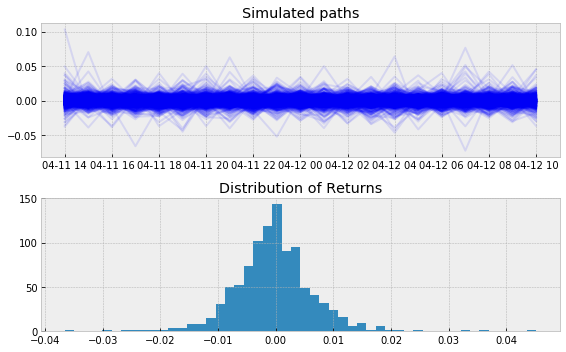

In [16]:
arch_f_sims = arch_f.simulations

p('Percentile of simulation values = {:.6}'.format(np.percentile(arch_f_sims.values[-1, :, -1].T, 5)))

fig, ax = plt.subplots(2, sharex=False, figsize=(8, 5))

plt.sca(ax[0])
plt.plot(forecast_idx, arch_f_sims.values[-1, :, :].T, color='blue', alpha=0.1)
plt.title('Simulated paths')

plt.sca(ax[1])
plt.hist(arch_f_sims.values[-1, :, -1], bins=50)
plt.title('Distribution of Returns')

plt.tight_layout()

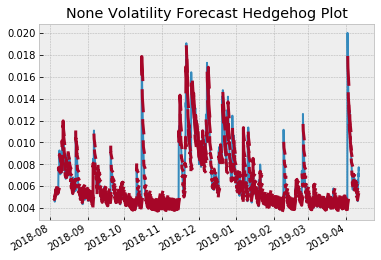

In [17]:
fig = arch_res.hedgehog_plot(horizon=forecast_steps)
fig.autofmt_xdate()

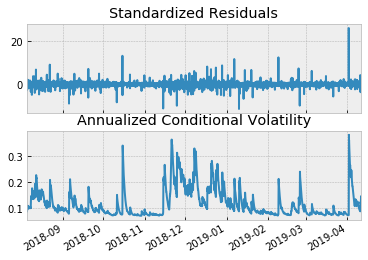

In [18]:
fig = arch_res.plot(annualize=freq, scale=365)
fig.autofmt_xdate()

# From Medium
https://medium.com/auquan/time-series-analysis-for-finance-arch-garch-models-822f87f1d755

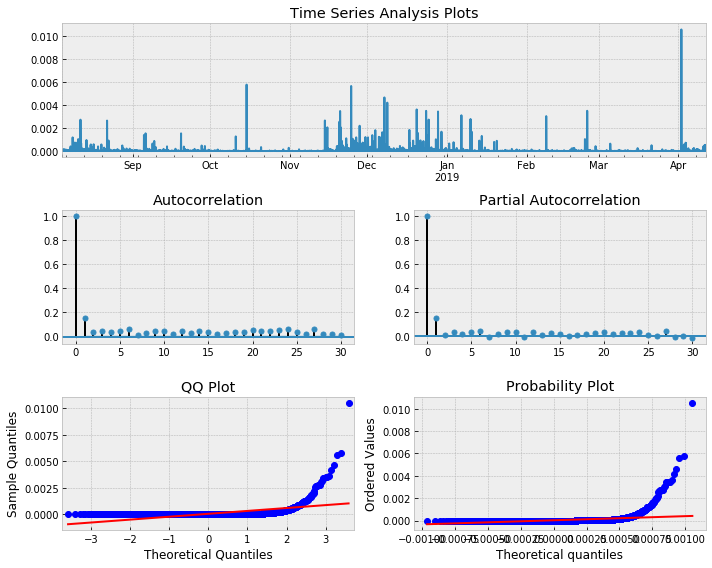

In [19]:
tsplot(arch_res.resid**2, lags=max_lag)

In [20]:
Y_ = Y.iloc[-1000:]
window = 72
foreLength = forecast_steps + window
signal = Y_[-foreLength:]
signal.head()

2019-04-07 18:00:00   -0.000341
2019-04-07 19:00:00    0.000609
2019-04-07 20:00:00    0.002995
2019-04-07 21:00:00    0.002590
2019-04-07 22:00:00    0.004259
Freq: H, Name: log_returns, dtype: float64

In [21]:
def backtest(Y, foreLength, window, signal, frequency, order=None):
    for d in range(foreLength):
        TS = Y[(d + 1):(d + window)] 
        
        if order:
            best_mdl = smt.ARIMA(TS, order=order, freq=frequency).fit(method='mle', trend='nc')
        else:
            _, order, best_mdl = _get_best_arima(TS)
        
        p_, o_, q_ = order
        if p_ == o_ == 0:
            p_ = 1
        
        arch_mdl = arch.arch_model(best_mdl.resid, p=p_, o=o_, q=q_, dist='StudentsT')
        res = arch_mdl.fit(update_freq=5, disp='off')
        forecast = res.forecast(horizon=1, start=None, align='origin')
        # Set trading signal equal to the sign of forecasted return
        signal.iloc[d] = np.sign(forecast.mean['h.1'].iloc[-1])
    return signal

In [22]:
signal = backtest(Y_, foreLength, window, signal, freq)

/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/.conda/envs/crypto_predict/

ARIMA Results: best aic = -728.71394 | best order = (0, 0, 1)


/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimiz

/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: Convergenc

/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: Convergenc

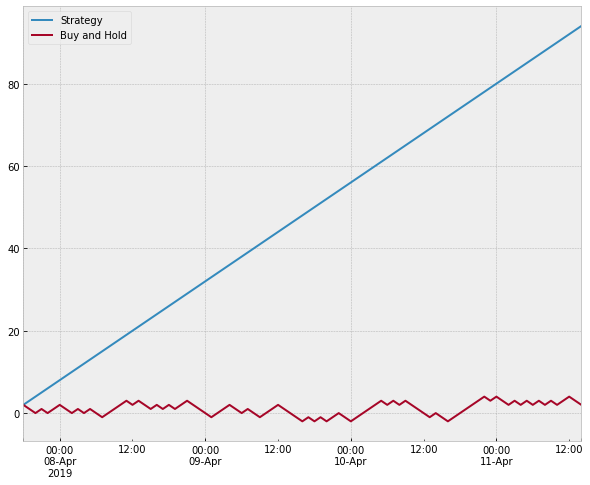

In [23]:
returns = pd.DataFrame(index=signal.index, columns=['Buy and Hold', 'Strategy'])
returns['Buy and Hold'] = Y_.iloc[-foreLength:]
returns['Strategy'] = signal * returns['Buy and Hold']

eqCurves = pd.DataFrame(index=signal.index, columns=['Buy and Hold', 'Strategy'])
eqCurves['Buy and Hold'] = returns['Buy and Hold'].cumsum() + 1
eqCurves['Strategy'] = returns['Strategy'].cumsum() + 1

fig, ax = plt.subplots(figsize=(10, 8))
eqCurves['Strategy'].plot()
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()

# From Arch website

In [24]:
ar = ARX(Y, lags=max_lag)
ar.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     AR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.242
Mean Model:                        AR   Adj. R-squared:                  0.238
Vol Model:          Constant Variance   Log-Likelihood:                4766.46
Distribution:                  Normal   AIC:                          -9468.91
Method:            Maximum Likelihood   BIC:                          -9254.70
                                        No. Observations:                 5968
Date:                Mon, Apr 15 2019   Df Residuals:                     5936
Time:                        11:46:36   Df Model:                           32
                                    Mean Model                                   
=================================================================================
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const          6.6920e-04  1.366e-03      0.490      0.624 [-2.009e-03,3.347e-03]
log_...rns[1]     -0.2537  8.797e-02     -2.884  3.929e-03   [ -0.426,-8.127e-02]
log_...rns[2]     -0.0447      0.110     -0.406      0.685      [ -0.261,  0.171]
log_...rns[3]     -0.1216      0.102     -1.189      0.234    [ -0.322,7.886e-02]
log_...rns[4]     -0.2357      0.109     -2.155  3.116e-02   [ -0.450,-2.133e-02]
log_...rns[5]     -0.0930      0.115     -0.812      0.417      [ -0.318,  0.132]
log_...rns[6]     -0.1397      0.115     -1.210      0.226    [ -0.366,8.654e-02]
log_...rns[7]     -0.2180      0.107     -2.036  4.176e-02   [ -0.428,-8.135e-03]
log_...rns[8]     -0.1681      0.115     -1.460      0.144    [ -0.394,5.756e-02]
log_...rns[9]     -0.2053      0.117     -1.752  7.982e-02    [ -0.435,2.440e-02]
log_...rns[10]    -0.0185      0.115     -0.161      0.872      [ -0.244,  0.207]
log_...rns[11]    -0.1185      0.125     -0.950      0.342      [ -0.363,  0.126]
log_...rns[12]    -0.2185      0.124     -1.762  7.812e-02    [ -0.462,2.459e-02]
log_...rns[13]    -0.2017      0.132     -1.531      0.126    [ -0.460,5.658e-02]
log_...rns[14]    -0.0986      0.120     -0.819      0.413      [ -0.334,  0.137]
log_...rns[15]     0.0897      0.129      0.695      0.487      [ -0.163,  0.342]
log_...rns[16]    -0.0324      0.121     -0.268      0.789      [ -0.270,  0.205]
log_...rns[17]     0.0559      0.134      0.416      0.677      [ -0.207,  0.319]
log_...rns[18]     0.0283      0.132      0.215      0.830      [ -0.230,  0.286]
log_...rns[19]     0.0627      0.127      0.493      0.622      [ -0.187,  0.312]
log_...rns[20]    -0.1673      0.138     -1.211      0.226      [ -0.438,  0.104]
log_...rns[21]    -0.0587      0.127     -0.463      0.643      [ -0.307,  0.190]
log_...rns[22]     0.1097      0.131      0.838      0.402      [ -0.147,  0.366]
log_...rns[23]     0.0656      0.132      0.496      0.620      [ -0.194,  0.325]
log_...rns[24]     0.0388      0.147      0.264      0.792      [ -0.249,  0.327]
log_...rns[25]    -0.0316      0.141     -0.224      0.823      [ -0.309,  0.245]
log_...rns[26]     0.1569      0.136      1.157      0.247      [ -0.109,  0.423]
log_...rns[27]     0.0412      0.126      0.327      0.744      [ -0.206,  0.288]
log_...rns[28]    -0.0445      0.144     -0.310      0.757      [ -0.326,  0.237]
log_...rns[29]    -0.0569      0.127     -0.447      0.655      [ -0.306,  0.192]
log_...rns[30]    -0.0255      0.124     -0.205      0.838      [ -0.269,  0.218]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------

In [25]:
ar.volatility = GARCH(p=3, o=0, q=3)
res = ar.fit(update_freq=0, disp='off')
res.summary()

/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.242
Mean Model:                        AR   Adj. R-squared:                  0.238
Vol Model:                      GARCH   Log-Likelihood:                13777.0
Distribution:                  Normal   AIC:                          -27477.9
Method:            Maximum Likelihood   BIC:                          -27223.5
                                        No. Observations:                 5968
Date:                Mon, Apr 15 2019   Df Residuals:                     5930
Time:                        11:46:36   Df Model:                           38
                                    Mean Model                                    
==================================================================================
                      coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------------------------
Const          -6.6487e-05  8.789e-05     -0.756      0.449 [-2.388e-04,1.058e-04]
log_...rns[1]      -0.2536  4.889e-02     -5.187  2.140e-07      [ -0.349, -0.158]
log_...rns[2]      -0.0447  3.181e-02     -1.405      0.160    [ -0.107,1.765e-02]
log_...rns[3]      -0.1216  3.601e-02     -3.377  7.341e-04   [ -0.192,-5.101e-02]
log_...rns[4]      -0.2356  3.561e-02     -6.616  3.687e-11      [ -0.305, -0.166]
log_...rns[5]      -0.0930  4.526e-02     -2.054  3.997e-02   [ -0.182,-4.259e-03]
log_...rns[6]      -0.1397  4.919e-02     -2.840  4.516e-03   [ -0.236,-4.327e-02]
log_...rns[7]      -0.2179  3.644e-02     -5.980  2.225e-09      [ -0.289, -0.147]
log_...rns[8]      -0.1680  4.210e-02     -3.991  6.576e-05   [ -0.251,-8.550e-02]
log_...rns[9]      -0.2052  4.081e-02     -5.028  4.947e-07      [ -0.285, -0.125]
log_...rns[10]     -0.0186  3.353e-02     -0.553      0.580 [-8.427e-02,4.717e-02]
log_...rns[11]     -0.1185  3.620e-02     -3.273  1.064e-03   [ -0.189,-4.753e-02]
log_...rns[12]     -0.2184  4.558e-02     -4.793  1.645e-06      [ -0.308, -0.129]
log_...rns[13]     -0.2016  4.516e-02     -4.465  8.012e-06      [ -0.290, -0.113]
log_...rns[14]     -0.0986  3.536e-02     -2.787  5.313e-03   [ -0.168,-2.926e-02]
log_...rns[15]      0.0897  5.803e-02      1.545      0.122   [-2.407e-02,  0.203]
log_...rns[16]     -0.0324  5.277e-02     -0.614      0.539    [ -0.136,7.103e-02]
log_...rns[17]      0.0558  3.024e-02      1.847  6.482e-02   [-3.430e-03,  0.115]
log_...rns[18]      0.0283  3.144e-02      0.901      0.367 [-3.327e-02,8.995e-02]
log_...rns[19]      0.0627  2.995e-02      2.092  3.643e-02    [3.958e-03,  0.121]
log_...rns[20]     -0.1673  5.417e-02     -3.088  2.018e-03   [ -0.273,-6.108e-02]
log_...rns[21]     -0.0587  7.422e-02     -0.791      0.429    [ -0.204,8.673e-02]
log_...rns[22]      0.1096  4.410e-02      2.486  1.292e-02    [2.320e-02,  0.196]
log_...rns[23]      0.0656  2.689e-02      2.438  1.478e-02    [1.285e-02,  0.118]
log_...rns[24]      0.0387  2.878e-02      1.346      0.178 [-1.768e-02,9.514e-02]
log_...rns[25]     -0.0316  2.784e-02     -1.136      0.256 [-8.618e-02,2.295e-02]
log_...rns[26]      0.1569  6.855e-02      2.288  2.213e-02    [2.250e-02,  0.291]
log_...rns[27]      0.0412  5.297e-02      0.778      0.436   [-6.258e-02,  0.145]
log_...rns[28]     -0.0445  3.249e-02     -1.370      0.171    [ -0.108,1.917e-02]
log_...rns[29]     -0.0569  2.517e-02     -2.259  2.390e-02   [ -0.106,-7.519e-03]
log_...rns[30]     -0.0255  2.332e-02     -1.092      0.275 [-7.117e-02,2.024e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------

In [26]:
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp='off')
res.summary()

/Users/daniel_stevenson/.conda/envs/crypto_predict/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                  log_returns   R-squared:                  -42536.113
Mean Model:                              AR   Adj. R-squared:             -42751.055
Vol Model:                            GARCH   Log-Likelihood:               -18686.7
Distribution:      Standardized Student's t   AIC:                           37451.3
Method:                  Maximum Likelihood   BIC:                           37712.4
                                              No. Observations:                 5968
Date:                      Mon, Apr 15 2019   Df Residuals:                     5929
Time:                              11:46:38   Df Model:                           39
                                   Mean Model                                  
===============================================================================
                     coef    std err          t      P>|t|     95.0% Conf. Int.
-------------------------------------------------------------------------------
Const             -1.3685      0.265     -5.159  2.487e-07    [ -1.888, -0.849]
log_...rns[1]     61.7171     12.941      4.769  1.851e-06    [ 36.353, 87.081]
log_...rns[2]    -58.9437     22.800     -2.585  9.732e-03 [-1.036e+02,-14.256]
log_...rns[3]     83.6556     14.989      5.581  2.388e-08  [ 54.278,1.130e+02]
log_...rns[4]    -40.2723     14.175     -2.841  4.495e-03    [-68.054,-12.491]
log_...rns[5]    -16.6045     46.210     -0.359      0.719 [-1.072e+02, 73.966]
log_...rns[6]    -78.0932     16.735     -4.666  3.065e-06 [-1.109e+02,-45.293]
log_...rns[7]     28.8463     18.092      1.594      0.111    [ -6.613, 64.305]
log_...rns[8]     18.4810     11.942      1.548      0.122    [ -4.924, 41.886]
log_...rns[9]     16.4278      7.673      2.141  3.229e-02    [  1.388, 31.468]
log_...rns[10]   -23.9318     15.537     -1.540      0.123    [-54.383,  6.520]
log_...rns[11]   -28.2295     58.570     -0.482      0.630 [-1.430e+02, 86.567]
log_...rns[12]    34.2609     18.292      1.873  6.107e-02    [ -1.591, 70.113]
log_...rns[13]    41.9441     18.108      2.316  2.054e-02    [  6.454, 77.434]
log_...rns[14]    24.8981     14.274      1.744  8.110e-02    [ -3.078, 52.874]
log_...rns[15]   -12.0900     52.768     -0.229      0.819 [-1.155e+02, 91.333]
log_...rns[16]    10.8574     14.218      0.764      0.445    [-17.009, 38.724]
log_...rns[17]    25.2190     29.843      0.845      0.398    [-33.273, 83.711]
log_...rns[18]     8.6857     14.901      0.583      0.560    [-20.520, 37.891]
log_...rns[19]   -51.9610     10.934     -4.752  2.010e-06    [-73.391,-30.531]
log_...rns[20]     2.1525     39.529  5.445e-02      0.957    [-75.324, 79.629]
log_...rns[21]   -42.7209     14.316     -2.984  2.844e-03    [-70.780,-14.662]
log_...rns[22]    -7.5839     19.749     -0.384      0.701    [-46.291, 31.123]
log_...rns[23]   -11.8139      5.805     -2.035  4.184e-02    [-23.192, -0.436]
log_...rns[24]     2.9663      8.656      0.343      0.732    [-13.999, 19.932]
log_...rns[25]    52.6173     20.739      2.537  1.118e-02    [ 11.969, 93.266]
log_...rns[26]    18.6931     30.658      0.610      0.542    [-41.395, 78.781]
log_...rns[27]    16.0048      5.541      2.889  3.870e-03    [  5.145, 26.864]
log_...rns[28]   -24.1769     15.126     -1.598      0.110    [-53.823,  5.469]
log_...rns[29]     8.4535     26.132      0.323      0.746    [-42.765, 59.672]
log_...rns[30]    53.0464     31.815      1.667  9.545e-02  [ -9.311,1.154e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------

In [27]:
ar_forecast = ar.forecast(horizon=forecast_steps, start=Y.index[-1], params=res.params, method='simulation')

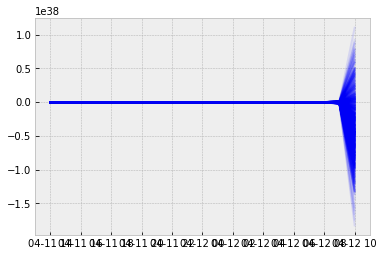

In [28]:
ar_forecast_simulations = ar_forecast.simulations.values[-1].T
plt.plot(forecast_idx, ar_forecast_simulations, color='blue', alpha=0.1)
plt.show()

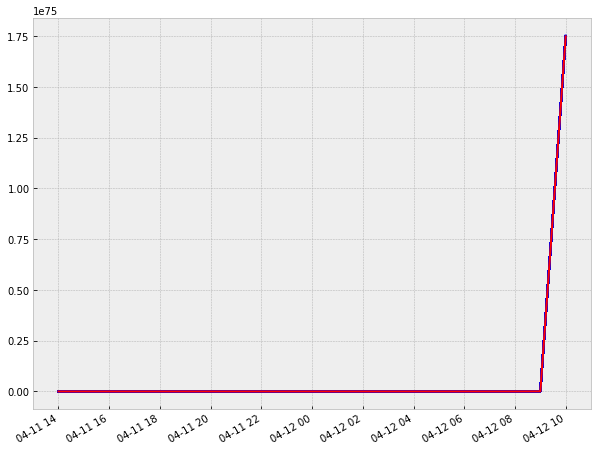

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(forecast_idx, ar_forecast.simulations.variances[-1,::].T, color='blue', alpha=0.1, label='simulated var')
plt.plot(forecast_idx, ar_forecast.variance.iloc[-1], color='red', label='expected var')
fig.autofmt_xdate()
plt.show()